# Read Raw Data radar

## NOTED
In this document, the process of converting raw data into range profile information will be explained. In this experiment, I utilized the IWR1843+ DCA1000EVM radar to collect raw data. During the experiment, data acquisition was performed at a distance of 0.5 meters from the radar.
* In this documentation, I perform radar data acquisition for a contactless vital sign detection application, specifically focusing on the breathing rate.

* This document will provide code examples for processing radar data to obtain information about the breathing rate.

## Parameter Configuration 
* number of ADC samples : 200 
* number chirp per frame : 2
* number of Rx : 4
* time record : 2 minute
* Fs = 4000000
* c = 3e8
* slope2 = 40845000000000.0
* slope = 70e6

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

fileName ='Raw_S3_24bpm_0.5m.bin'

In [2]:
def read_raw(fileName):
    numADCSamples = 200 # number of ADC samples per chirp
    numADCBits = 16 # number of ADC bits per sample
    numRX = 4 # number of receivers
    numLanes = 2 # do not change. number of lanes is always 2
    isReal = 0 # set to 1 if real only data, 0 if complex data0
    fid = open(fileName,'rb')
    adcData = np.fromfile(fid, dtype='int16')
    if numADCBits != 16:
        l_max = 2**(numADCBits-1)-1
        adcData[adcData > l_max] = adcData[adcData > l_max] - 2**numADCBits
    fid.close()
    fileSize = adcData.shape[0]

    if isReal:
        numChirps = fileSize//numADCSamples//numRX
        LVDS = np.zeros((fileSize,), dtype=np.int16)
        LVDS = adcData.reshape(numADCSamples*numRX, numChirps, order='F').T
    else:
        numChirps = fileSize//2//numADCSamples//numRX
        LVDS = np.zeros((fileSize//2,), dtype=np.complex64)
        counter = 0
        for i in range(0, fileSize-1, 4):
            LVDS[counter] = adcData[i] + 1j*adcData[i+2]
            LVDS[counter+1] = adcData[i+1] + 1j*adcData[i+3]
            counter += 2
        LVDS = LVDS.reshape(numADCSamples*numRX, numChirps, order='F').T

    adcData = np.zeros((numRX,numChirps*numADCSamples), dtype=np.complex64)
    for row in range(numRX):
        for i in range(numChirps):
            adcData[row, i*numADCSamples:(i+1)*numADCSamples] = LVDS[i, row*numADCSamples:(row+1)*numADCSamples]

    retVal = adcData
    return retVal

In [3]:
Radar_data = read_raw(fileName)

In [4]:
# Setting Radar
n_rx = 4 
n_fft = 1024
n_adc = 200
n_chirp = 2
# Reshape Data 
raw_data = Radar_data
raw_new =raw_data.reshape((n_rx,n_adc*n_chirp,-1), order='F')
raw_new.shape
data_len = raw_new.shape[2]
data_len


2400

### Range FFT and MTI (Moving Target Indicator)

In [5]:
from scipy.fft import fft, fftfreq, fftshift
def Range_FFT(InputData):
    OutputData = np.zeros((n_rx, n_fft, data_len), dtype=complex)
    dc_removal = np.zeros((n_rx, n_adc*2 , data_len), dtype=complex)
    for i in range(n_rx):
        for j in range(data_len):
#             window = np.hamming(params['n_fft']//4)
            dc_removal[i,:,j]= InputData[i,:,j] - np.mean(InputData[i,:,j])
            OutputData[i,:,j]= fft((dc_removal[i,:,j]), n=n_fft)
    return OutputData

def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], n_fft, hasil_fft.shape[-1]),dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],n_adc*2, hasil_fft.shape[-1]),dtype=complex)
    alpha = 0.01
    for i in np.arange(hasil_fft.shape[0]):
        for j in np.arange(1,hasil_fft.shape[-1]):
            clutter[i,:,j] = np.dot(alpha,hasil_fft[i,:,j])+ np.dot((1-alpha),clutter[i,:,j-1])
            OutputData[i,:,j] = hasil_fft[i,np.arange(n_adc*2),j]-(clutter[i,range(0,n_adc*2),j])
    return OutputData

In [6]:
# Range FFT plus dc removal 
FFT_hasil = Range_FFT(raw_new) # Range FFT
# FFT_result.shape
Hasil_mti = MTI(FFT_hasil)

In [7]:
mti_rx1 = np.array(Hasil_mti[0,:,:]) # An-1
mti_rx2 = np.array(Hasil_mti[1,:,:]) # An-2
mti_rx3 = np.array(Hasil_mti[2,:,:])# An-3
mti_rx4 = np.array(Hasil_mti[3,:,:]) # An-4

# Ploting Data 

Range Subject :  0.5524553571428571 m


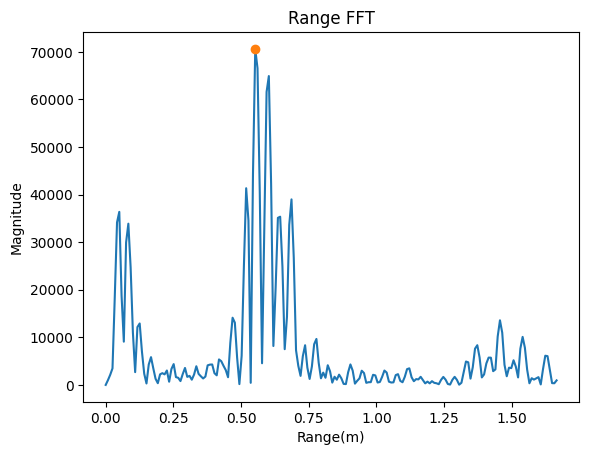

In [8]:
range_fft1 = FFT_hasil[0,:,:]
col1 = range_fft1[:,10]
numADCSamples = 1024
Fs = 4000000
c = 3e8
slope2 = 40845000000000.0
slope = 70e6
slope =slope//1e-6
index = np.arange(1, numADCSamples+1)
freq_bin = (index-1) * Fs / numADCSamples
range_bin2 = freq_bin * c / 2 / slope
peak = np.argmax(abs(col1[:70]))
print("Range Subject : ", range_bin2[peak],"m")
# range_data = 
plt.title("Range FFT")
plt.plot(range_bin2[:200],abs(col1[:200]))
plt.plot(range_bin2[:200][peak],abs(col1[:200][peak]),"o")
plt.xlabel("Range(m)")
plt.ylabel("Magnitude")
plt.show()

Range Subject :  0.5524553571428571 m


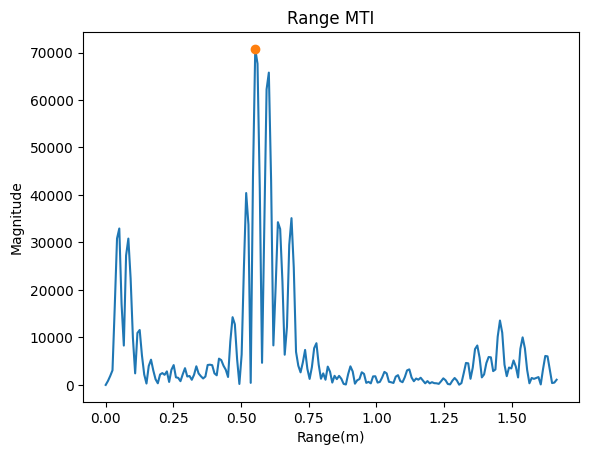

In [9]:
range_mti1 = mti_rx1 
col1 = range_mti1[:,10]
numADCSamples = 1024
Fs = 4000000
c = 3e8
slope2 = 40845000000000.0
slope = 70e6
slope =slope//1e-6
index = np.arange(1, numADCSamples+1)
freq_bin = (index-1) * Fs / numADCSamples
range_bin2 = freq_bin * c / 2 / slope
peak = np.argmax(abs(col1[:70]))
print("Range Subject : ", range_bin2[peak],"m")
# range_data = 
plt.title("Range MTI")
plt.plot(range_bin2[:200],abs(col1[:200]))
plt.plot(range_bin2[:200][peak],abs(col1[:200][peak]),"o")
plt.xlabel("Range(m)")
plt.ylabel("Magnitude")
plt.show()

# Range Bin Selection

In [10]:
def map_loc(data_mti):
    Range_Map_An1 =[]
    index_max =[]
    for i in range(1,data_len):
    # Input data From MTI each Antenna 
        awal_an1 = data_mti[:,i] 
        abs_mti_1 = abs(awal_an1)
        peak_loc_an1 = np.argmax(abs_mti_1[25:150])
        rslt_peak_1 = 25+peak_loc_an1
        map_loc_an1 = awal_an1[rslt_peak_1]
        index_max.append(abs(rslt_peak_1))
        Range_Map_An1.append(map_loc_an1)
    return index_max, Range_Map_An1

In [11]:
 # Range Map Location 
Antena1 = np.array(Hasil_mti[0,:,:],dtype='object')
Antena2 = np.array(Hasil_mti[1,:,:],dtype='object')
Antena3 = np.array(Hasil_mti[2,:,:],dtype='object')
Antena4 = np.array(Hasil_mti[3,:,:],dtype='object')

In [12]:
##Map Lokasinya 
# Ini adalah data range_bin 
map_locA1,Map_loc_An1 = np.array(map_loc(Antena1))
map_locA2,Map_loc_An2 = np.array(map_loc(Antena2))
map_locA3,Map_loc_An3 = np.array(map_loc(Antena3))
map_locA4,Map_loc_An4 = np.array(map_loc(Antena4))

## Phase Extraction

In [13]:
def dacm(data):
    psi=[]
    for i in range(1,data.shape[-1]):
        I = data[i].real
        Q = data[i].imag
        I_2 = data[i-1].real
        Q_2 = data[i-1].imag
        phase = (I*(Q- Q_2))-((I-I_2)*Q)
        phase2 = phase/((I**2)+(Q**2))
        psi.append(phase2)
    return psi

In [14]:
DACM_An1 = np.array(dacm(Map_loc_An1), dtype='object')
DACM_An2 = np.array(dacm(Map_loc_An2), dtype='object')
DACM_An3 = np.array(dacm(Map_loc_An3), dtype='object')
DACM_An4 = np.array(dacm(Map_loc_An4), dtype='object')

## Remove Impulse Noise

In [15]:
def filter_RemoveImpulseNoise(dataPrev2, dataPrev1, dataCurr, thresh):
    pDataIn = []
    pDataIn.append(dataPrev2)
    pDataIn.append(dataPrev1)
    pDataIn.append(dataCurr)

    backwardDiff = pDataIn[1] - pDataIn[0]
    forwardDiff = pDataIn[1] - pDataIn[2]

    x1 = 0
    x2 = 2
    y1 = pDataIn[0]
    y2 = pDataIn[2]
    x = 1

    if ((forwardDiff > thresh and backwardDiff > thresh) or (forwardDiff < -thresh and backwardDiff < -thresh)):
        y = y1 + ((x - x1) * (y2 - y1) / (x2 - x1))
    else:
        y = pDataIn[1]
        
    return y

def remove_noise(delta_phase):
    thresh= 0.8
    data_hasil= []
#     n = (delta_phase.shape[0])-3
    for i in range(len(delta_phase)-3):# mulai data index ke-3 # mulai data index ke-3 
        dataPrev2 = delta_phase[i]# data[0] -> data(1)
        dataPrev1 = delta_phase[i+1]# data[1] -> data(2)
        dataCurr  = delta_phase[i+2] # data[2]
    #data_prev1.append(dataPrev1)
        y = filter_RemoveImpulseNoise(dataPrev2, dataPrev1, dataCurr, thresh)
        data_hasil.append(y)
    # data_hasil_AN = np.array(data_hasil)   
    return data_hasil


In [16]:
NR_1 = np.array(remove_noise(DACM_An1),dtype=object)
NR_2 = np.array(remove_noise(DACM_An2),dtype=object)
NR_3 = np.array(remove_noise(DACM_An3),dtype=object)
NR_4 = np.array(remove_noise(DACM_An4),dtype=object)

## Fitering

In [17]:
from scipy.signal import butter, sosfiltfilt, filtfilt
def _butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="band", output="sos")
    return sos
def butter_bandpass_filter(signal, lowcut, highcut, fs, order):
    sos = _butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, signal)
    return y

# Breathing Waveform

In [18]:
low = 0.1
high = 32/60
fs = 20
BPF_RR1 = np.array(butter_bandpass_filter(NR_1,low,high,fs,order=3))
BPF_RR2 = np.array(butter_bandpass_filter(NR_2,low,high,fs,order=3))
BPF_RR3 = np.array(butter_bandpass_filter(NR_3,low,high,fs,order=3))
BPF_RR4 = np.array(butter_bandpass_filter(NR_4,low,high,fs,order=3))


Text(0, 0.5, 'Amplitude')

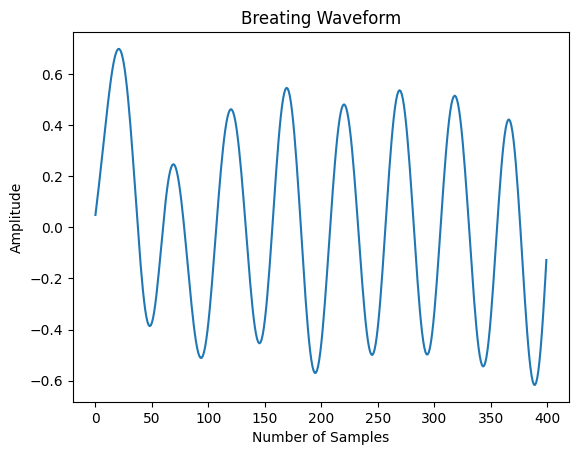

In [21]:
plt.plot(BPF_RR1[:400])
plt.title("Breating Waveform")
plt.xlabel('Number of Samples')
plt.ylabel("Amplitude")

In [22]:
# Fungsi untuk menghitung amplitudo spektrum yang sudah dinormalisasi
def fft_sinyal(signal):
    sample_rate = 20
    
     # Melakukan FFT pada sinyal
    fft_data = np.fft.fft(signal)
    
    # Menghitung magnitudo spektrum FFT
    fft_magnitude = np.abs(fft_data)
    # Normalisasi amplitudo
    normalized_amplitude = 2.0 / len(signal) * fft_magnitude

    freq_axis = np.fft.fftfreq(len(signal), 1/sample_rate)
    
    # Ambil hanya data frekuensi positif
    freq_axis = freq_axis[:len(freq_axis)//2]
    normalized_amplitude = normalized_amplitude[:len(normalized_amplitude)//2]
    
    return freq_axis, normalized_amplitude

Breathing Rate :  24.0


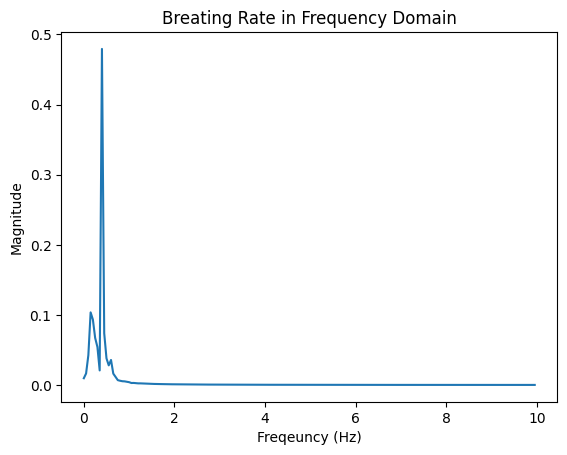

In [26]:
# calculate breathing rate using fft 
data_wave = BPF_RR1[:400] # used 20s with sampling rate 20 Hz
freq, fft_result = fft_sinyal(data_wave)
peak_br = np.argmax(fft_result[:50])
print("Breathing Rate : ", freq[peak_br]*60) # calculate the BR 
plt.title("Breating Rate in Frequency Domain")
plt.plot(freq,fft_result)
plt.xlabel('Freqeuncy (Hz)')
plt.ylabel("Magnitude")
plt.show()
